In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_curve

%matplotlib inline

In [2]:
path='dataset/train.csv'
df=pd.read_csv(path)
df

,customer_id,name,age,gender,owns_car,owns_house,no_of_children,net_yearly_income,no_of_days_employed,occupation_type,total_family_members,migrant_worker,yearly_debt_payments,credit_limit,credit_limit_used(%),credit_score,prev_defaults,default_in_last_6months,credit_card_default
0,CST_115179,ita Bose,46,F,N,Y,0.0,107934.04,612.0,Unknown,1.0,1.0,33070.28,18690.93,73,544.0,2,1,1
1,CST_121920,Alper Jonathan,29,M,N,Y,0.0,109862.62,2771.0,Laborers,2.0,0.0,15329.53,37745.19,52,857.0,0,0,0
2,CST_109330,Umesh Desai,37,M,N,Y,0.0,230153.17,204.0,Laborers,2.0,0.0,48416.60,41598.36,43,650.0,0,0,0
3,CST_128288,Rie,39,F,N,Y,0.0,122325.82,11941.0,Core staff,2.0,0.0,22574.36,32627.76,20,754.0,0,0,0
4,CST_151355,McCool,46,M,Y,Y,0.0,387286.00,1459.0,Core staff,1.0,0.0,38282.95,52950.64,75,927.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45523,CST_130421,Doris,55,F,N,N,2.0,96207.57,117.0,Unknown,4.0,0.0,11229.54,29663.83,82,907.0,0,0,0
45524,CST_136670,Luciana,31,F,N,Y,0.0,383476.74,966.0,Accountants,2.0,1.0,43369.91,139947.16,32,679.0,0,0,0
45525,CST_145435,Jessica,27,F,N,Y,0.0,260052.18,1420.0,Core staff,2.0,0.0,22707.51,83961.83,46,727.0,0,0,0
45526,CST_130913,Tessa,32,M,Y,N,0.0,157363.04,2457.0,Laborers,2.0,0.0,20150.10,25538.72,92,805.0,0,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45528 entries, 0 to 45527
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   customer_id              45528 non-null  object 
 1   name                     45528 non-null  object 
 2   age                      45528 non-null  int64  
 3   gender                   45528 non-null  object 
 4   owns_car                 44981 non-null  object 
 5   owns_house               45528 non-null  object 
 6   no_of_children           44754 non-null  float64
 7   net_yearly_income        45528 non-null  float64
 8   no_of_days_employed      45065 non-null  float64
 9   occupation_type          45528 non-null  object 
 10  total_family_members     45445 non-null  float64
 11  migrant_worker           45441 non-null  float64
 12  yearly_debt_payments     45433 non-null  float64
 13  credit_limit             45528 non-null  float64
 14  credit_limit_used(%)  

In [4]:
df2=df.copy()
df2.drop(columns=['customer_id','name'], inplace=True)
df2=df2.rename(columns={'owns_car':'car', 'owns_house':'house', 'no_of_children':'children', 'net_yearly_income':'income', 'no_of_days_employed':'employment', 'occupation_type':'occupation', 'total_family_members':'family', 'migrant_worker':'migrant', 'yearly_debt_payments':'debt', 'credit_limit_used(%)':'credit_used', 'default_in_last_6months':'default_in6', 'credit_card_default':'default'})
df2

,age,gender,car,house,children,income,employment,occupation,family,migrant,debt,credit_limit,credit_used,credit_score,prev_defaults,default_in6,default
0,46,F,N,Y,0.0,107934.04,612.0,Unknown,1.0,1.0,33070.28,18690.93,73,544.0,2,1,1
1,29,M,N,Y,0.0,109862.62,2771.0,Laborers,2.0,0.0,15329.53,37745.19,52,857.0,0,0,0
2,37,M,N,Y,0.0,230153.17,204.0,Laborers,2.0,0.0,48416.60,41598.36,43,650.0,0,0,0
3,39,F,N,Y,0.0,122325.82,11941.0,Core staff,2.0,0.0,22574.36,32627.76,20,754.0,0,0,0
4,46,M,Y,Y,0.0,387286.00,1459.0,Core staff,1.0,0.0,38282.95,52950.64,75,927.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45523,55,F,N,N,2.0,96207.57,117.0,Unknown,4.0,0.0,11229.54,29663.83,82,907.0,0,0,0
45524,31,F,N,Y,0.0,383476.74,966.0,Accountants,2.0,1.0,43369.91,139947.16,32,679.0,0,0,0
45525,27,F,N,Y,0.0,260052.18,1420.0,Core staff,2.0,0.0,22707.51,83961.83,46,727.0,0,0,0
45526,32,M,Y,N,0.0,157363.04,2457.0,Laborers,2.0,0.0,20150.10,25538.72,92,805.0,0,0,0


In [5]:
df2=df2.drop([28498])
df2.gender.value_counts()

F    29957
M    15570
Name: gender, dtype: int64

In [6]:
df2.gender.value_counts()

F    29957
M    15570
Name: gender, dtype: int64

In [7]:
df2.house.value_counts()

Y    31641
N    13886
Name: house, dtype: int64

In [8]:
df2.car.value_counts()

N    29742
Y    15238
Name: car, dtype: int64

D:\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='children'>

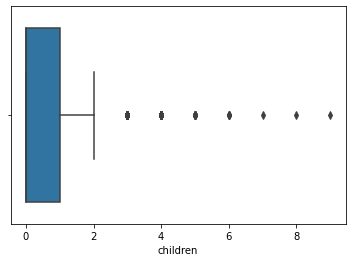

In [9]:
sns.boxplot(df2.children)

In [10]:
df2['children'].value_counts()

0.0    31241
1.0     8985
2.0     3861
3.0      584
4.0       60
5.0       13
6.0        6
8.0        1
7.0        1
9.0        1
Name: children, dtype: int64

In [11]:
df2=df2[df2['children']<7] 

In [12]:
df2['income'].describe()

count    4.475000e+04
mean     2.007690e+05
std      6.747552e+05
min      2.717061e+04
25%      1.262745e+05
50%      1.716603e+05
75%      2.407018e+05
max      1.407590e+08
Name: income, dtype: float64

<AxesSubplot:xlabel='income'>

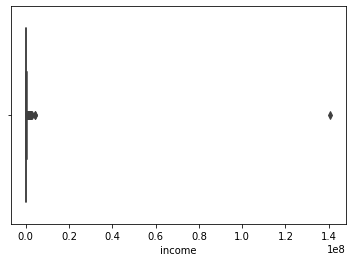

In [13]:
sns.boxplot(x=df2['income'])

In [14]:
# len(df2[df2['income']>1*1e6])

df2=df2[df2['income']<1.5*1e6]

D:\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='employment'>

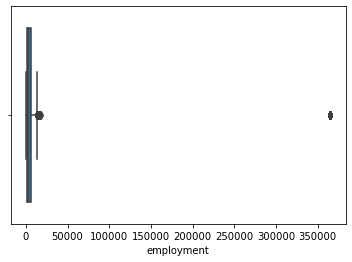

In [15]:
sns.boxplot(df2['employment'])

In [16]:
df2[df2['employment']>3*1e5]

,age,gender,car,house,children,income,employment,occupation,family,migrant,debt,credit_limit,credit_used,credit_score,prev_defaults,default_in6,default
12,39,F,N,Y,0.0,68421.10,365247.0,Unknown,2.0,0.0,13781.53,17110.01,72,643.0,1,1,1
29,26,M,Y,N,0.0,172067.42,365251.0,Unknown,2.0,0.0,24199.23,22155.88,49,886.0,0,0,0
32,32,M,Y,N,0.0,206413.69,365247.0,Unknown,2.0,0.0,22419.59,74423.73,72,766.0,0,0,0
45,50,F,Y,Y,0.0,173396.95,365241.0,Unknown,1.0,0.0,10764.89,28296.94,3,811.0,0,0,0
48,48,F,N,N,0.0,145514.36,365240.0,Unknown,1.0,0.0,27222.39,39851.78,22,717.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45509,28,F,N,N,0.0,109872.55,365252.0,Unknown,2.0,0.0,17022.95,23985.85,56,798.0,0,0,0
45510,38,F,N,Y,0.0,52827.82,365242.0,Unknown,2.0,0.0,19245.70,13756.60,13,907.0,0,0,0
45512,24,F,N,Y,0.0,140729.06,365251.0,Unknown,2.0,0.0,18350.70,15661.53,27,752.0,0,0,0
45513,49,M,N,Y,0.0,223193.44,365242.0,Unknown,2.0,0.0,19881.38,48985.19,72,940.0,0,0,0


In [17]:
df2.occupation.value_counts()

Unknown                  14056
Laborers                  7985
Sales staff               4631
Core staff                3991
Managers                  3108
Drivers                   2707
High skill tech staff     1653
Accountants               1453
Medicine staff            1252
Security staff            1011
Cooking staff              881
Cleaning staff             650
Private service staff      385
Low-skill Laborers         333
Waiters/barmen staff       199
Secretaries                194
Realty agents               99
HR staff                    77
IT staff                    66
Name: occupation, dtype: int64

D:\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='family'>

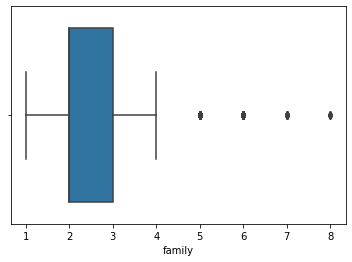

In [18]:
sns.boxplot(df2['family'])

In [19]:
df2[df2['family']>7]

,age,gender,car,house,children,income,employment,occupation,family,migrant,debt,credit_limit,credit_used,credit_score,prev_defaults,default_in6,default
4871,36,M,Y,N,6.0,168692.48,1044.0,Unknown,8.0,1.0,28518.20,23818.27,69,860.0,0,0,0
12250,29,M,Y,N,6.0,229706.64,1088.0,Laborers,8.0,1.0,26634.15,72883.16,92,921.0,0,0,0
32300,26,F,Y,N,6.0,140594.06,1589.0,Unknown,8.0,1.0,33305.86,45470.69,65,943.0,0,0,0
32760,54,M,Y,Y,6.0,124473.67,2613.0,Laborers,8.0,1.0,14351.48,34656.73,91,817.0,0,0,0
40945,38,M,N,N,6.0,184041.97,1491.0,High skill tech staff,8.0,0.0,20594.45,42754.68,95,731.0,0,0,0
42212,29,M,Y,Y,6.0,383017.78,2363.0,High skill tech staff,8.0,1.0,34122.39,78274.98,41,752.0,0,0,0


In [20]:
#sns.countplot(df['prev_defaults'])
df2['family'].value_counts()

2.0    23046
1.0     9720
3.0     7696
4.0     3561
5.0      553
6.0       55
7.0       12
8.0        6
Name: family, dtype: int64

D:\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='debt'>

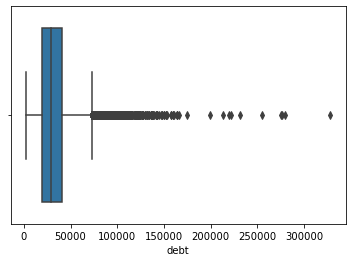

In [21]:
sns.boxplot(df2['debt'])

In [22]:
# df2[df2['debt']>1.5*1e5]

df2=df2[df2['debt']<2*1e5]

D:\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='credit_limit'>

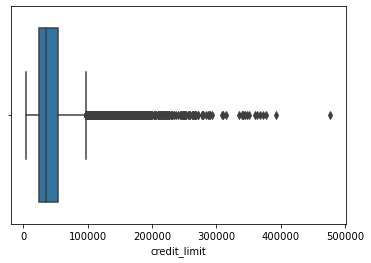

In [23]:
sns.boxplot(df2['credit_limit'])

In [23]:
# df2[df2['credit_limit']>3*1e5]
df2=df2[df2['credit_limit']<4*1e5]

D:\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='credit_used'>

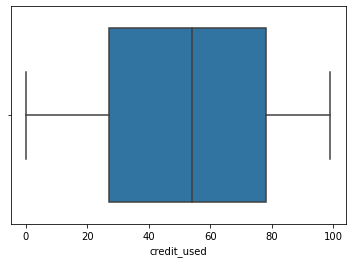

In [24]:
sns.boxplot(df2['credit_used'])

D:\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='credit_score'>

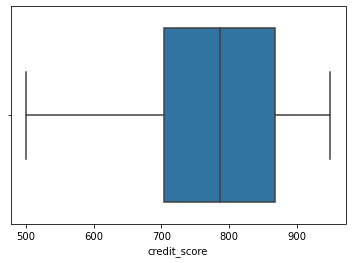

In [25]:
sns.boxplot(df2['credit_score'])

In [26]:
df2=df2.dropna()
len(df2)

43476

In [27]:
df2.describe()

,age,children,income,employment,family,migrant,debt,credit_limit,credit_used,credit_score,prev_defaults,default_in6,default
count,43476.000000,43476.000000,4.347600e+04,43476.000000,43476.000000,43476.000000,43476.000000,43476.000000,43476.000000,43476.000000,43476.000000,43476.000000,43476.000000
mean,38.997171,0.420232,1.967085e+05,67672.234842,2.158133,0.179708,31756.961922,42659.773295,52.235969,782.791931,0.060815,0.050764,0.081148
std,9.543189,0.721610,1.085652e+05,139375.998316,0.910154,0.383949,16952.072004,28255.012025,29.381083,100.595047,0.264486,0.219517,0.273066
min,23.000000,0.000000,2.717061e+04,2.000000,1.000000,0.000000,2237.470000,4003.140000,0.000000,500.000000,0.000000,0.000000,0.000000
25%,31.000000,0.000000,1.262597e+05,937.000000,2.000000,0.000000,19235.987500,23973.160000,27.000000,704.000000,0.000000,0.000000,0.000000
50%,39.000000,0.000000,1.715915e+05,2224.000000,2.000000,0.000000,29089.425000,35677.635000,54.000000,786.000000,0.000000,0.000000,0.000000
75%,47.000000,1.000000,2.406066e+05,5820.250000,3.000000,0.000000,40555.940000,53432.082500,79.000000,867.000000,0.000000,0.000000,0.000000
max,55.000000,6.000000,1.450487e+06,365252.000000,8.000000,1.000000,199119.180000,392073.190000,99.000000,949.000000,2.000000,1.000000,1.000000


In [28]:
stdScaler=StandardScaler()
mnmxScaler=MinMaxScaler()

In [30]:
df3=df2.copy()

In [29]:
def scaleDf(df,df2,column):
    scaler=StandardScaler()
    scaler.fit(np.array(df[column]).reshape(-1,1))
    df[column]=scaler.transform(np.array(df[column]).reshape(-1,1))
    df2[column]=scaler.transform(np.array(df2[column]).reshape(-1,1))

In [30]:
def mscaleDf(df,df2,column):
    scaler=MinMaxScaler()
    scaler.fit(np.array(df[column]).reshape(-1,1))
    df[column]=scaler.transform(np.array(df[column]).reshape(-1,1))
    df2[column]=scaler.transform(np.array(df2[column]).reshape(-1,1))

In [40]:
scaleDf(df2,df_test,'income')
scaleDf(df2,df_test,'employment')
scaleDf(df2,df_test,'debt')
scaleDf(df2,df_test,'credit_limit')
scaleDf(df2,df_test,'credit_score')

In [41]:
mscaleDf(df2,df_test,'age')
# mscaleDf(df2,'income')
# mscaleDf(df2,'employment')
mscaleDf(df2,df_test,'family')
# mscaleDf(df2,'debt')
# mscaleDf(df2,'credit_limit')
mscaleDf(df2,df_test,'credit_used')
# mscaleDf(df2,'credit_score')

In [42]:
df_test.describe()

,age,children,income,employment,family,migrant,debt,credit_limit,credit_used,credit_score,prev_defaults,default_in6
count,11383.000000,11383.000000,11383.000000,11383.000000,11383.000000,11383.000000,11383.000000,11383.000000,11383.000000,11383.000000,11383.000000,11383.000000
mean,0.502281,0.412018,0.018422,-0.015444,0.165309,0.177633,0.018995,0.011058,0.523040,0.015880,0.058069,0.048669
std,0.299140,0.723603,1.061039,0.982505,0.130882,0.382221,1.026469,1.037906,0.296830,0.998623,0.260202,0.215185
min,0.000000,0.000000,-1.532724,-0.485564,0.000000,0.000000,-1.733449,-1.382253,0.000000,-2.811224,0.000000,0.000000
25%,0.250000,0.000000,-0.637970,-0.478780,0.142857,0.000000,-0.720529,-0.655157,0.262626,-0.768356,0.000000,0.000000
50%,0.500000,0.000000,-0.219584,-0.469464,0.142857,0.000000,-0.146451,-0.243014,0.535354,0.041832,0.000000,0.000000
75%,0.750000,1.000000,0.400920,-0.443706,0.285714,0.000000,0.527618,0.384648,0.787879,0.866932,0.000000,0.000000
max,1.000000,11.000000,20.962228,2.135111,1.714286,1.000000,14.650754,13.408654,1.000000,1.652268,2.000000,1.000000


In [43]:
df2['employment']=df2['employment']/2

df2['debt']=df2['debt']/6

df_test['employment']=df_test['employment']/2

df_test['debt']=df_test['debt']/6

In [44]:
enc = OneHotEncoder(handle_unknown='ignore')

In [45]:
enc.fit(np.array(df2['occupation']).reshape(-1,1))

OneHotEncoder(handle_unknown='ignore')

In [46]:
enc.get_feature_names()[:10]

array(['x0_Accountants', 'x0_Cleaning staff', 'x0_Cooking staff',
       'x0_Core staff', 'x0_Drivers', 'x0_HR staff',
       'x0_High skill tech staff', 'x0_IT staff', 'x0_Laborers',
       'x0_Low-skill Laborers'], dtype=object)

In [47]:
occ=pd.DataFrame(enc.transform(np.array(df2['occupation']).reshape(-1,1)).toarray(),columns=enc.get_feature_names())

In [48]:
df2.reset_index(inplace=True)

In [49]:
df2=pd.concat([df2,occ],axis=1)

In [50]:
occ=pd.DataFrame(enc.transform(np.array(df_test['occupation']).reshape(-1,1)).toarray(),columns=enc.get_feature_names())

In [51]:
df_test.reset_index(inplace=True)
df_test=pd.concat([df_test,occ],axis=1)

In [52]:
df2['gender'].replace(['F','M'],[0,1],inplace=True)
df_test['gender'].replace(['F','M'],[0,1],inplace=True)

In [53]:
df2['car'].replace(['N','Y'],[0,1],inplace=True)
df_test['car'].replace(['N','Y'],[0,1],inplace=True)

In [54]:
df2['house'].replace(['N','Y'],[0,1],inplace=True)
df_test['house'].replace(['N','Y'],[0,1],inplace=True)

In [55]:
# lenc=LabelEncoder()

In [56]:
# df2.occupation=lenc.fit_transform(df2['occupation']).reshape(-1,1) 

In [57]:
target=df2.default

In [58]:
df2=df2.drop(['index','children','occupation','default'],axis=1)
df_test=df_test.drop(['index','children','occupation',],axis=1)

In [59]:
df2.isna().sum()

age                         0
gender                      0
car                         0
house                       0
income                      0
employment                  0
family                      0
migrant                     0
debt                        0
credit_limit                0
credit_used                 0
credit_score                0
prev_defaults               0
default_in6                 0
x0_Accountants              0
x0_Cleaning staff           0
x0_Cooking staff            0
x0_Core staff               0
x0_Drivers                  0
x0_HR staff                 0
x0_High skill tech staff    0
x0_IT staff                 0
x0_Laborers                 0
x0_Low-skill Laborers       0
x0_Managers                 0
x0_Medicine staff           0
x0_Private service staff    0
x0_Realty agents            0
x0_Sales staff              0
x0_Secretaries              0
x0_Security staff           0
x0_Unknown                  0
x0_Waiters/barmen staff     0
dtype: int

In [60]:
len(df_test)

11383

In [61]:
x_train,x_test,y_train,y_test=train_test_split(df2,target,test_size=0.3,random_state=60)

In [59]:
clf=LogisticRegression(random_state=43)
solvers=['newton-cg', 'lbfgs', 'liblinear']
penalty=['l2']
c_values=[10,1,0.1,0.01]

In [61]:
grid= dict(solver=solvers, penalty=penalty, C=c_values)
cv= RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search= GridSearchCV(estimator=clf, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy', error_score=0)
grid_result= grid_search.fit(x_train, y_train)

In [62]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.980803 using {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.979432 (0.001918) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.979423 (0.001900) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.979509 (0.001948) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.979691 (0.001811) with: {'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.979691 (0.001811) with: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.980103 (0.001718) with: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
0.980803 (0.001754) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.980803 (0.001754) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.980717 (0.001678) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.980755 (0.001665) with: {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}
0.980755 (0.001665) with: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
0.980583 (0.001659) with: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}


In [102]:
clf=LogisticRegression(C=0.155, solver='newton-cg',penalty='l2')

In [103]:
clf.fit(df2,target)

LogisticRegression(C=0.155, solver='newton-cg')

In [104]:
y_pred=clf.predict(x_test)

In [105]:
f1_score(y_test,y_pred) 

0.8583464981569247

In [82]:
fpr, tpr, thresholds= roc_curve(y_test, clf.predict_proba(x_test)[:,1])

In [83]:
i=np.arange(len(tpr))
roc=pd.DataFrame({'fpr':pd.Series(fpr, index=i), 'tpr':pd.Series(tpr, index=i), 'threshold':pd.Series(thresholds, index=i), 'tf':pd.Series(tpr-(1-fpr), index=i)})

In [84]:
roc

,fpr,tpr,threshold,tf
0,0.000000,0.000000,1.999989e+00,-1.000000
1,0.000000,0.000930,9.999891e-01,-0.999070
2,0.000000,0.768372,5.854784e-01,-0.231628
3,0.000084,0.768372,5.195717e-01,-0.231544
4,0.000084,0.771163,5.052438e-01,-0.228754
...,...,...,...,...
393,0.106086,0.998140,4.035388e-02,0.104225
394,0.106086,0.999070,4.032077e-02,0.105156
395,0.126818,0.999070,3.038848e-02,0.125888
396,0.126818,1.000000,3.037794e-02,0.126818


In [85]:
roc.iloc[(roc.tf-0).abs().argsort()[:1]]

,fpr,tpr,threshold,tf
301,0.046481,0.953488,0.113452,-0.000031


In [31]:
path1='dataset/test.csv'
df_test=pd.read_csv(path1)
df_test

,customer_id,name,age,gender,owns_car,owns_house,no_of_children,net_yearly_income,no_of_days_employed,occupation_type,total_family_members,migrant_worker,yearly_debt_payments,credit_limit,credit_limit_used(%),credit_score,prev_defaults,default_in_last_6months
0,CST_142525,Siva,52,F,Y,N,0.0,232640.53,998.0,Unknown,2.0,0.0,14406.73,26524.40,4,779.0,0,0
1,CST_129215,Scott,48,F,N,N,1.0,284396.79,1338.0,Unknown,3.0,0.0,57479.99,68998.72,70,806.0,0,0
2,CST_138443,Victoria,50,F,N,N,1.0,149419.28,1210.0,Unknown,3.0,0.0,21611.01,25187.80,71,528.0,2,0
3,CST_123812,John McCrank,30,F,N,N,1.0,160437.54,503.0,Laborers,2.0,1.0,28990.76,29179.39,9,815.0,0,0
4,CST_144450,Martinne,52,M,N,Y,0.0,233480.37,157.0,Laborers,2.0,1.0,54213.72,82331.82,82,613.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11378,CST_142412,Solarina,53,F,N,N,0.0,266824.38,3051.0,Sales staff,1.0,0.0,17791.56,64483.93,74,823.0,0,0
11379,CST_107967,Jonathan Cable,33,F,NaN,N,0.0,124310.85,365248.0,Unknown,1.0,0.0,26576.79,29851.73,60,712.0,0,0
11380,CST_134002,Robin,27,M,Y,Y,1.0,364652.81,3431.0,Laborers,3.0,0.0,28658.55,69336.96,67,674.0,0,0
11381,CST_146856,Lauren,36,F,N,Y,0.0,128769.02,16320.0,Medicine staff,1.0,0.0,11527.38,26908.03,17,684.0,0,0


In [32]:
df_test=df_test.rename(columns={'owns_car':'car', 'owns_house':'house', 'no_of_children':'children', 'net_yearly_income':'income', 'no_of_days_employed':'employment', 'occupation_type':'occupation', 'total_family_members':'family', 'migrant_worker':'migrant', 'yearly_debt_payments':'debt', 'credit_limit_used(%)':'credit_used', 'default_in_last_6months':'default_in6'})

In [33]:
df_test.isna().sum()

customer_id        0
name               0
age                0
gender             0
car              132
house              0
children         190
income             0
employment       105
occupation         0
family            31
migrant           26
debt              22
credit_limit       0
credit_used        0
credit_score       3
prev_defaults      0
default_in6        0
dtype: int64

In [34]:
df_test.describe()

,age,children,income,employment,family,migrant,debt,credit_limit,credit_used,credit_score,prev_defaults,default_in6
count,11383.000000,11193.000000,1.138300e+04,11278.000000,11352.000000,11357.000000,11361.000000,11383.000000,11383.000000,11380.000000,11383.000000,11383.000000
mean,39.073004,0.419012,1.987084e+05,65519.798280,2.157593,0.178040,32078.968043,42972.207247,51.780989,784.389455,0.058069,0.048669
std,9.572474,0.727709,1.151905e+05,137572.106971,0.917391,0.382563,17417.412533,29325.712903,29.386130,100.468636,0.260202,0.215185
min,23.000000,0.000000,3.030994e+04,-3.000000,1.000000,0.000000,2371.740000,3604.650000,0.000000,500.000000,0.000000,0.000000
25%,31.000000,0.000000,1.274479e+05,934.250000,2.000000,0.000000,19522.320000,24148.525000,26.000000,705.000000,0.000000,0.000000
50%,39.000000,0.000000,1.728695e+05,2216.000000,2.000000,0.000000,29246.110000,35793.490000,53.000000,787.000000,0.000000,0.000000
75%,47.000000,1.000000,2.402339e+05,5517.000000,3.000000,0.000000,40729.260000,53527.890000,78.000000,870.000000,0.000000,0.000000
max,55.000000,11.000000,2.472450e+06,365252.000000,13.000000,1.000000,280114.740000,421517.090000,99.000000,949.000000,2.000000,1.000000


In [35]:
df_test['car']=df_test['car'].fillna('N')
df_test['children']=df_test['children'].fillna(0)
df_test['employment']=df_test['employment'].fillna(65519)
df_test['family']=df_test['family'].fillna(2)
df_test['migrant']=df_test['migrant'].fillna(0)
df_test['debt']=df_test['debt'].fillna(32078)
df_test['credit_score']=df_test['credit_score'].fillna(784)

In [36]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11383 entries, 0 to 11382
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   customer_id    11383 non-null  object 
 1   name           11383 non-null  object 
 2   age            11383 non-null  int64  
 3   gender         11383 non-null  object 
 4   car            11383 non-null  object 
 5   house          11383 non-null  object 
 6   children       11383 non-null  float64
 7   income         11383 non-null  float64
 8   employment     11383 non-null  float64
 9   occupation     11383 non-null  object 
 10  family         11383 non-null  float64
 11  migrant        11383 non-null  float64
 12  debt           11383 non-null  float64
 13  credit_limit   11383 non-null  float64
 14  credit_used    11383 non-null  int64  
 15  credit_score   11383 non-null  float64
 16  prev_defaults  11383 non-null  int64  
 17  default_in6    11383 non-null  int64  
dtypes: flo

In [37]:
id=pd.Series(df_test['customer_id'])
id

0        CST_142525
1        CST_129215
2        CST_138443
3        CST_123812
4        CST_144450
            ...    
11378    CST_142412
11379    CST_107967
11380    CST_134002
11381    CST_146856
11382    CST_112001
Name: customer_id, Length: 11383, dtype: object

In [38]:
df_test=df_test.drop(['customer_id','name'], axis=1)

In [39]:
df_test

,age,gender,car,house,children,income,employment,occupation,family,migrant,debt,credit_limit,credit_used,credit_score,prev_defaults,default_in6
0,52,F,Y,N,0.0,232640.53,998.0,Unknown,2.0,0.0,14406.73,26524.40,4,779.0,0,0
1,48,F,N,N,1.0,284396.79,1338.0,Unknown,3.0,0.0,57479.99,68998.72,70,806.0,0,0
2,50,F,N,N,1.0,149419.28,1210.0,Unknown,3.0,0.0,21611.01,25187.80,71,528.0,2,0
3,30,F,N,N,1.0,160437.54,503.0,Laborers,2.0,1.0,28990.76,29179.39,9,815.0,0,0
4,52,M,N,Y,0.0,233480.37,157.0,Laborers,2.0,1.0,54213.72,82331.82,82,613.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11378,53,F,N,N,0.0,266824.38,3051.0,Sales staff,1.0,0.0,17791.56,64483.93,74,823.0,0,0
11379,33,F,N,N,0.0,124310.85,365248.0,Unknown,1.0,0.0,26576.79,29851.73,60,712.0,0,0
11380,27,M,Y,Y,1.0,364652.81,3431.0,Laborers,3.0,0.0,28658.55,69336.96,67,674.0,0,0
11381,36,F,N,Y,0.0,128769.02,16320.0,Medicine staff,1.0,0.0,11527.38,26908.03,17,684.0,0,0


In [76]:
path2='dataset/sample_submission.csv'
df3=pd.read_csv(path2)
df3

,customer_id,credit_card_default
0,CST_115179,1
1,CST_121920,0
2,CST_109330,0
3,CST_128288,0
4,CST_151355,0


In [106]:
df_test

,age,gender,car,house,income,employment,family,migrant,debt,credit_limit,...,x0_Low-skill Laborers,x0_Managers,x0_Medicine staff,x0_Private service staff,x0_Realty agents,x0_Sales staff,x0_Secretaries,x0_Security staff,x0_Unknown,x0_Waiters/barmen staff
0,0.90625,0,1,0,0.330976,-0.239191,0.142857,0.0,-0.170583,-0.571069,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.78125,0,0,0,0.807712,-0.237971,0.285714,0.0,0.252902,0.932197,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.84375,0,0,0,-0.435588,-0.238431,0.285714,0.0,-0.099752,-0.618374,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.21875,0,0,0,-0.334097,-0.240967,0.142857,1.0,-0.027197,-0.477103,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.90625,1,0,1,0.338712,-0.242208,0.142857,1.0,0.220789,1.404087,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11378,0.93750,0,0,0,0.645849,-0.231826,0.000000,0.0,-0.137304,0.772408,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
11379,0.31250,0,0,0,-0.666866,1.067541,0.000000,0.0,-0.050930,-0.453307,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
11380,0.12500,1,1,1,1.546963,-0.230463,0.285714,0.0,-0.030463,0.944169,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11381,0.40625,0,0,1,-0.625801,-0.184224,0.000000,0.0,-0.198892,-0.557491,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [107]:
df_test['gender'].replace('XNA',0,inplace=True)
df_test.gender.value_counts()

0    7444
1    3939
Name: gender, dtype: int64

In [108]:
test_predict=pd.Series(clf.predict(df_test))

In [109]:
test_predict

0        0
1        0
2        1
3        0
4        1
        ..
11378    0
11379    0
11380    0
11381    0
11382    0
Length: 11383, dtype: int64

In [110]:
result=pd.DataFrame({'customer_id':id, 'credit_card_default':test_predict})
result

,customer_id,credit_card_default
0,CST_142525,0
1,CST_129215,0
2,CST_138443,1
3,CST_123812,0
4,CST_144450,1
...,...,...
11378,CST_142412,0
11379,CST_107967,0
11380,CST_134002,0
11381,CST_146856,0


In [111]:
result.to_csv('result.csv')